In [1]:
import networkx as nx
import itertools
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from rdkit.Chem import AllChem, DataStructs
import json
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
import tensorflow as tf

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_classification
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')

2023-06-28 15:14:57.786321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 15:15:03.822341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
g = nx.read_graphml("./graph/train_graph.gml")
species_features_dummy = pd.read_csv("./data/species_features.csv.gz", index_col=0)
#species_features_dummy = pd.read_csv("./data/species_BaseNEncoder.csv.gz", index_col=0)
#species_features_dummy = pd.read_csv("./data/species_Multi_dim_scale.csv.gz", index_col=0)
molecule_features_dummy = pd.read_csv("./data/molecule_features.csv.gz", index_col=0).astype("int8")
df_agg = pd.read_csv("./data/lotus_agg_train.csv.gz", index_col=0)
#molecule_features_dummy = pd.read_csv("./data/molecule_features_dummy.csv.gz", index_col=0).astype('int8')

In [4]:
species_test = species_features_dummy[~species_features_dummy.index.isin(df_agg.organism_name)].index
mol_test = molecule_features_dummy[~molecule_features_dummy.index.isin(df_agg.structure_smiles_2D)].index

In [5]:
species_feat = species_features_dummy[species_features_dummy.index.isin(df_agg.organism_name)]
molecule_feat = molecule_features_dummy[molecule_features_dummy.index.isin(df_agg.structure_smiles_2D)]

In [6]:
G = StellarGraph.from_networkx(g,
                               node_features={'species':species_feat,
                                              'molecule': molecule_feat})
print(G.info())
G.check_graph_for_ml()

StellarDiGraph: Directed multigraph
 Nodes: 162374, Edges: 700916

 Node types:
  molecule: [127088]
    Features: float32 vector, length 27
    Edge types: molecule-present_in->species
  species: [35286]
    Features: float32 vector, length 70
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [350458]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [350458]
        Weights: all 1 (default)
        Features: none


In [7]:
batch_size = 256 #default: 200
epochs = 50 #default: 20
num_samples = [1, 1]
num_workers = multiprocessing.cpu_count()-2

In [8]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.3 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=False, edge_label="present_in"
)

Network has 350458 edges of type present_in
Network has 350458 edges of type present_in
** Sampled 35045 positive and 35045 negative edges. **


In [9]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.3 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=False, edge_label="present_in"
)

Network has 315413 edges of type present_in
Network has 315413 edges of type present_in
** Sampled 31541 positive and 31541 negative edges. **


In [10]:
print(G_train.info())

StellarDiGraph: Directed multigraph
 Nodes: 162374, Edges: 634330

 Node types:
  molecule: [127088]
    Features: float32 vector, length 27
    Edge types: molecule-present_in->species
  species: [35286]
    Features: float32 vector, length 70
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [350458]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [283872]
        Weights: all 1 (default)
        Features: none


In [11]:
print(G_test.info())

StellarDiGraph: Directed multigraph
 Nodes: 162374, Edges: 665871

 Node types:
  molecule: [127088]
    Features: float32 vector, length 27
    Edge types: molecule-present_in->species
  species: [35286]
    Features: float32 vector, length 70
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [350458]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [315413]
        Weights: all 1 (default)
        Features: none


In [12]:
train_gen = HinSAGELinkGenerator(G_train,
                                 batch_size=batch_size,
                                 num_samples=num_samples,
                                 head_node_types=["molecule", "species"])
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [13]:
test_gen = HinSAGELinkGenerator(G_test,
                                batch_size=batch_size,
                                num_samples=num_samples,
                                head_node_types=["molecule", "species"])
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [14]:
hinsage_layer_sizes = [256, 256]
hinsage = HinSAGE(layer_sizes=hinsage_layer_sizes,
                  generator=train_gen,
                  bias=True,
                  dropout=0.3,
                 activations=['elu','selu'])

In [15]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = hinsage.in_out_tensors()

/usr/local/Caskroom/mambaforge/base/envs/stellar_graph/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [16]:
prediction = link_classification(output_dim=1,
                                 output_act="sigmoid",
                                 edge_embedding_method="l1")(x_out)

link_classification: using 'l1' method to combine node embeddings into edge embeddings


In [17]:
model = keras.Model(inputs=x_inp, outputs=prediction)

initial_learning_rate = 0.1
final_learning_rate = 0.00001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(edge_ids_train.shape[0]/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.binary_crossentropy,
    metrics=["AUC"],
)

In [18]:
init_train_metrics = model.evaluate(train_flow, workers=num_workers, verbose=2)
init_test_metrics = model.evaluate(test_flow, workers=num_workers, verbose=2)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

247/247 - 5s - loss: 0.6941 - auc: 0.5213 - 5s/epoch - 19ms/step
274/274 - 5s - loss: 0.6935 - auc: 0.5332 - 5s/epoch - 17ms/step

Train Set Metrics of the initial (untrained) model:
	loss: 0.6941
	auc: 0.5213

Test Set Metrics of the initial (untrained) model:
	loss: 0.6935
	auc: 0.5332


In [19]:
callbacks = keras.callbacks.EarlyStopping(monitor="val_loss",
                                          patience=10,
                                          mode="auto",
                                          restore_best_weights=True)

history = model.fit(train_flow,
                    epochs=epochs,
                    workers=num_workers,
                    validation_data=test_flow,
                    verbose=2,
                    callbacks=[callbacks],
                    validation_split=0.0,
                    shuffle=True
                   )

Epoch 1/50
247/247 - 18s - loss: 0.6238 - auc: 0.6962 - val_loss: 0.5505 - val_auc: 0.7833 - 18s/epoch - 72ms/step
Epoch 2/50
247/247 - 15s - loss: 0.5731 - auc: 0.7625 - val_loss: 0.5168 - val_auc: 0.8254 - 15s/epoch - 60ms/step
Epoch 3/50
247/247 - 14s - loss: 0.5534 - auc: 0.7839 - val_loss: 0.4898 - val_auc: 0.8432 - 14s/epoch - 56ms/step
Epoch 4/50
247/247 - 14s - loss: 0.5341 - auc: 0.8036 - val_loss: 0.4744 - val_auc: 0.8566 - 14s/epoch - 57ms/step
Epoch 5/50
247/247 - 14s - loss: 0.5238 - auc: 0.8134 - val_loss: 0.4647 - val_auc: 0.8628 - 14s/epoch - 57ms/step
Epoch 6/50
247/247 - 17s - loss: 0.5151 - auc: 0.8207 - val_loss: 0.4548 - val_auc: 0.8673 - 17s/epoch - 67ms/step
Epoch 7/50
247/247 - 15s - loss: 0.5101 - auc: 0.8254 - val_loss: 0.4453 - val_auc: 0.8745 - 15s/epoch - 60ms/step
Epoch 8/50
247/247 - 15s - loss: 0.5009 - auc: 0.8327 - val_loss: 0.4395 - val_auc: 0.8775 - 15s/epoch - 59ms/step
Epoch 9/50
247/247 - 15s - loss: 0.4991 - auc: 0.8344 - val_loss: 0.4342 - val_a

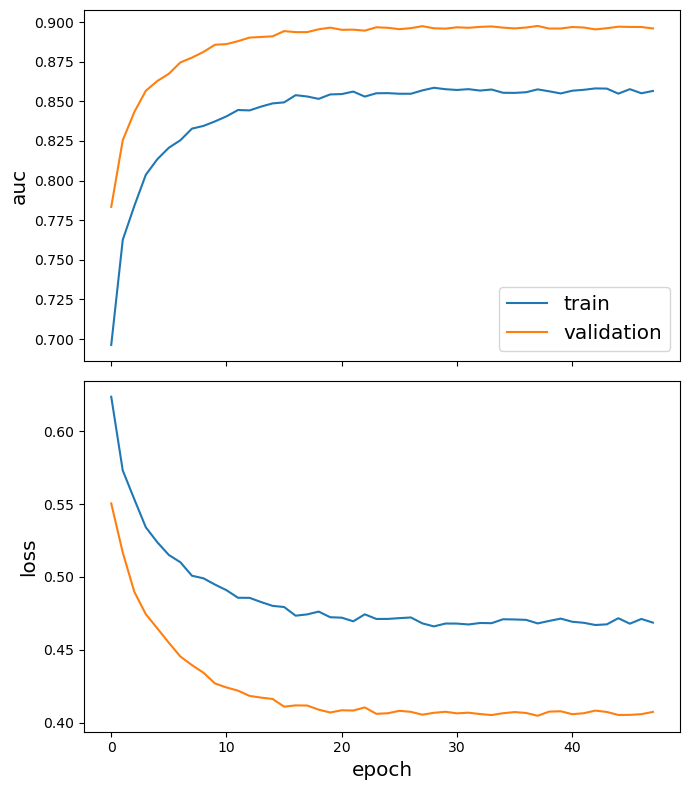

In [20]:
sg.utils.plot_history(history)

In [21]:
train_metrics = model.evaluate(train_flow, verbose=2)
test_metrics = model.evaluate(test_flow, verbose=2)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

247/247 - 4s - loss: 0.4064 - auc: 0.8977 - 4s/epoch - 16ms/step
274/274 - 6s - loss: 0.4085 - auc: 0.8953 - 6s/epoch - 23ms/step

Train Set Metrics of the trained model:
	loss: 0.4064
	auc: 0.8977

Test Set Metrics of the trained model:
	loss: 0.4085
	auc: 0.8953


In [22]:
test_pred = HinSAGELinkGenerator(G,
                                 batch_size=128,
                                num_samples=num_samples,
                                head_node_types=["molecule", "species"]).flow(edge_ids_test, edge_labels_test)

In [23]:
predictions = model.predict(test_pred, workers=3)

548/548 [==============================] - 6s 10ms/step


In [24]:
predictions = predictions.flatten()

In [25]:
test = predictions[(predictions>0.9) | (predictions<0.1)]
test = test>0.5

In [26]:
test = test.astype('int8')

(array([15279.,  5614.,  4164.,  3663.,  3589.,  4017.,  4681.,  6030.,
         9265., 13788.]),
 array([0.0011205 , 0.10089559, 0.20067067, 0.30044577, 0.40022087,
        0.49999595, 0.59977102, 0.6995461 , 0.79932123, 0.89909631,
        0.99887139]),
 <BarContainer object of 10 artists>)

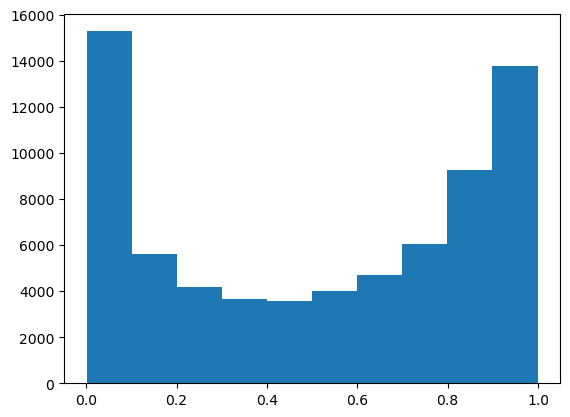

In [27]:
plt.hist(predictions)

In [28]:
np.where((predictions>0.9) | (predictions<0.1))

(array([    1,     2,     4, ..., 70079, 70086, 70088]),)

In [29]:
sum(test == edge_labels_test[np.where((predictions>0.9) | (predictions<0.1))])/len(test)

0.9643005540166205

In [30]:
len(test)/len(predictions)

0.41204166072192894

In [31]:
finaly_test = np.array(list(zip(df_agg.structure_smiles_2D[:1000],df_agg.organism_name[::-1][:1000])))

In [32]:
final_test = HinSAGELinkGenerator(G,
                                batch_size=128,
                                num_samples=num_samples,
                                head_node_types=["molecule", "species"]).flow(finaly_test, np.ones(len(finaly_test)).reshape(-1, 1))

In [33]:
res = model.predict(final_test).flatten()

8/8 [==============================] - 0s 8ms/step


In [34]:
res[res>0.9]

array([0.914911  , 0.96466744, 0.9374969 , 0.9236827 , 0.90433186,
       0.9235681 , 0.9320158 , 0.9041375 , 0.91655546, 0.91927683,
       0.9408582 , 0.9403737 , 0.9059589 , 0.9007321 , 0.9264311 ,
       0.90208715, 0.91879725, 0.9608725 , 0.9277797 , 0.9443395 ,
       0.9701238 , 0.9368689 , 0.9076524 , 0.95031947, 0.9815334 ,
       0.9121501 , 0.97862005, 0.9655075 , 0.92388797, 0.9680367 ,
       0.93185   , 0.9517224 , 0.9521613 , 0.95307195, 0.92093045,
       0.90350294, 0.9667944 , 0.9257951 , 0.9175781 , 0.9422196 ,
       0.94713116, 0.9371574 , 0.9353159 , 0.97187304, 0.92666245,
       0.9914796 , 0.9292204 , 0.9826276 , 0.94948685, 0.92345   ,
       0.9391552 , 0.9137295 , 0.90460956, 0.97498953, 0.90701294,
       0.92774343, 0.9537543 , 0.91858894, 0.91871905, 0.96068835,
       0.9127828 , 0.90245444, 0.91478497, 0.9055509 , 0.94393116,
       0.9257784 , 0.9311862 , 0.9083558 , 0.9440358 , 0.93427205,
       0.9178967 , 0.92116994], dtype=float32)

In [35]:
len(res[res>0.9])/len(res)

0.072

(array([ 61.,  75.,  75.,  73.,  81., 123., 115., 130., 181.,  86.]),
 array([0.01397435, 0.11172488, 0.2094754 , 0.30722591, 0.40497643,
        0.50272697, 0.60047746, 0.698228  , 0.79597855, 0.89372903,
        0.99147958]),
 <BarContainer object of 10 artists>)

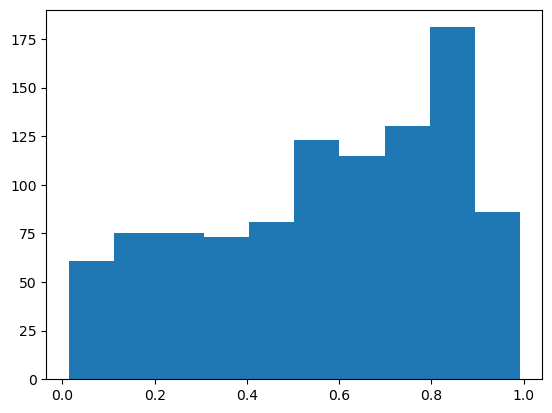

In [58]:
plt.hist(res)

In [36]:
finaly_test[res>0.9]

array([['CC1OC(OCC2OC(Oc3c(-c4ccc(O)c(O)c4)oc4cc(O)cc(O)c4c3=O)C(O)C(O)C2O)C(O)C(O)C1O',
        'Zygophyllum simplex'],
       ['O=C(O)C1OC(Oc2c(O)cc(O)c3c(=O)c(O)c(-c4ccc(O)c(O)c4)oc23)C(O)C(O)C1O',
        'Zygophyllum simplex'],
       ['CC1(C)C2CC3C(C2)C31C', 'Zygophyllum album'],
       ['CC12CCC(C1)C(C)(C)C2=O', 'Zygophyllum album'],
       ['COc1cc(-c2oc3cc(O)cc(O)c3c(=O)c2OC2OC(COC3OC(C)C(O)C(O)C3O)C(O)C(O)C2O)cc(OC)c1O',
        'Zuccagnia punctata'],
       ['CC(=O)OC1CC2CCC1(C)C2(C)C', 'Zostera marina'],
       ['CCC(CCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C)C(C)C',
        'Zosima korovinii'],
       ['NC(CCC(=O)O)C(=O)O', 'Zopfiella marina'],
       ['CC(C)(O)C1CC=C(C(=O)O)CC1', 'Zootermopsis angusticollis'],
       ['C=C1CCC=C(C)CCC2C1CC2(C)C', 'Zoegea baldschuanica'],
       ['CCC(CCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C)C(C)C',
        'Zizyphus vulgaris'],
       ['CCC(CCC(C)C1CCC2C3CC=C4CC(OC5OC(CO)C(O)C(O)C5O)CCC4(C)C3CCC12C)C(C)C',
        'Ziziphus spina-christi'],
 

(array([ 61.,  75.,  75.,  73.,  81., 123., 115., 130., 181.,  86.]),
 array([0.01397435, 0.11172488, 0.2094754 , 0.30722591, 0.40497643,
        0.50272697, 0.60047746, 0.698228  , 0.79597855, 0.89372903,
        0.99147958]),
 <BarContainer object of 10 artists>)

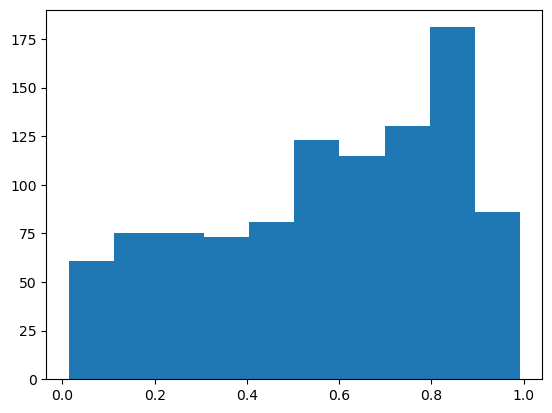

In [37]:
plt.hist(res)

In [38]:
org = df_agg.organism_name.unique()[:100]

In [39]:
mol = df_agg.structure_smiles_2D.unique()[:1000]

In [40]:
len(df_agg.structure_smiles_2D.unique())

127088

In [41]:
len(df_agg.organism_name.unique())

35286

In [42]:
%%time
combinations = list(itertools.product(mol, org))

CPU times: user 7.98 ms, sys: 1.51 ms, total: 9.48 ms
Wall time: 9.57 ms


In [43]:
%%time
A1, A2 = np.meshgrid(mol, org)

CPU times: user 802 µs, sys: 574 µs, total: 1.38 ms
Wall time: 1.37 ms


In [44]:
df_combinations = pd.DataFrame(combinations, columns=['structure_smiles_2D', 'organism_name'])

In [45]:
edge_test_final = df_combinations.to_numpy()

In [46]:
%%time
final_final_test = HinSAGELinkGenerator(G,
                                batch_size=256,
                                num_samples=num_samples,
                                head_node_types=["molecule", "species"]).flow(edge_test_final, np.ones(len(edge_test_final)).reshape(-1, 1))

CPU times: user 31.3 s, sys: 292 ms, total: 31.6 s
Wall time: 31.7 s


In [47]:
final_final_pred = model.predict(final_final_test).flatten()

391/391 [==============================] - 6s 15ms/step


In [48]:
len(final_final_pred)

100000

In [49]:
len(final_final_pred[final_final_pred>0.9])

10063

In [50]:
results = edge_test_final[final_final_pred>0.9]

In [51]:
results[10000:10100]

array([['CC(C)=CC(O)C(O)C(C)c1ccc(C)cc1', 'Abies nebrodensis'],
       ['CC(C)=CC(O)C(O)C(C)c1ccc(C)cc1', 'Abies nordmanniana'],
       ['CC(C)=CC(O)C(O)C(C)c1ccc(C)cc1', 'Abies pinsapo'],
       ['CC(C)=CC(O)C(O)C(C)c1ccc(C)cc1', 'Abies procera'],
       ['CC(C)=CC(O)C(O)C(C)c1ccc(C)cc1', 'Abutilon grandiflorum'],
       ['CC(C)=CC(O)C(O)C(C)c1ccc(C)cc1', 'Abutilon indicum'],
       ['CC(C)=CC(O)C(O)C(C)c1ccc(C)cc1', 'Abutilon persicum'],
       ['CC(=O)OC1CCC2(C)C(CCC3(C)C2CC=C2C4CC(C)(C)CCC4(C(=O)O)CCC23C)C1(C)C',
        'Abelia'],
       ['CC(=O)OC1CCC2(C)C(CCC3(C)C2CC=C2C4CC(C)(C)CCC4(C(=O)O)CCC23C)C1(C)C',
        'Abroma augustum'],
       ['CC1(C)CCC2(C)CC=C3C(C)(CCC4C3(C)CCC3C(C)(C)C(=O)CCC34C)C2C1',
        'Abies sachalinensis'],
       ['CN1CC(O)CC1C(=O)O', 'Abrotanella forsteroides'],
       ['CN1CC(O)CC1C(=O)O', 'Acacia angustissima'],
       ['COC(=O)C12CCC(C)(C)CC1C1=CCC3C4(C)CCC(OC(C)=O)C(C)(C)C4CCC3(C)C1(C)CC2',
        'Abelmoschus esculentus'],
       ['COC(=O)C12C

In [52]:
df_agg

,organism_name,structure_smiles_2D,reference_wikidata,organism_taxonomy_08genus,organism_taxonomy_06family,organism_taxonomy_05order,organism_taxonomy_04class,organism_taxonomy_03phylum,organism_taxonomy_02kingdom,organism_taxonomy_01domain,structure_taxonomy_classyfire_01kingdom,structure_taxonomy_classyfire_02superclass,structure_taxonomy_classyfire_03class,structure_taxonomy_classyfire_04directparent,total_papers_molecule,total_papers_species
0,Aaptos,COc1cc2c3c(ccnc3c1OC)NC=C2,2,Aaptos,Suberitidae,Suberitida,Demospongiae,Porifera,Metazoa,Eukaryota,Organic compounds,Organoheterocyclic compounds,Diazanaphthalenes,Naphthyridines,16,2
1,Aaptos aaptos,CC(C)CCCC(C)C1CCC2C3=CCC4CC(O)CCC4(C)C3CCC21C,1,Aaptos,Suberitidae,Suberitida,Demospongiae,Porifera,Metazoa,Eukaryota,Organic compounds,Lipids and lipid-like molecules,Steroids and steroid derivatives,Cholesterols and derivatives,42,38
2,Aaptos aaptos,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,1,Aaptos,Suberitidae,Suberitida,Demospongiae,Porifera,Metazoa,Eukaryota,Organic compounds,Lipids and lipid-like molecules,Steroids and steroid derivatives,Cholesterols and derivatives,585,38
3,Aaptos aaptos,CC(C)CCCC(C)C1CCC2C3CCC4CC(O)CCC4(C)C3CCC12C,1,Aaptos,Suberitidae,Suberitida,Demospongiae,Porifera,Metazoa,Eukaryota,Organic compounds,Lipids and lipid-like molecules,Steroids and steroid derivatives,Cholesterols and derivatives,94,38
4,Aaptos aaptos,COC1=Cc2ccnc3c2C1(O)C(CC(C)=O)=NC=C3,1,Aaptos,Suberitidae,Suberitida,Demospongiae,Porifera,Metazoa,Eukaryota,Organic compounds,Organoheterocyclic compounds,Azepines,Azepines,1,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438064,Zyzzya fuliginosa,O=C1C(NCCc2ccc(O)cc2)=CC2=NCCc3c[nH]c1c32,3,Zyzzya,Acarnidae,Poecilosclerida,Demospongiae,Porifera,Metazoa,Eukaryota,Organic compounds,Organoheterocyclic compounds,Quinolines and derivatives,"Pyrrolo[4,3,2-de]quinolines",4,124
438065,Zyzzya fuliginosa,O=C1C(NCCc2ccccc2)=CC2=NCCc3c[nH]c1c32,1,Zyzzya,Acarnidae,Poecilosclerida,Demospongiae,Porifera,Metazoa,Eukaryota,Organic compounds,Organoheterocyclic compounds,Quinolines and derivatives,"Pyrrolo[4,3,2-de]quinolines",1,124
438066,Zyzzya fuliginosa,O=C1C=C2SC3CC2(C=C1Br)c1c(c(=O)c2ncc4cc[nH]c1c...,2,Zyzzya,Acarnidae,Poecilosclerida,Demospongiae,Porifera,Metazoa,Eukaryota,Organic compounds,Organoheterocyclic compounds,Phenanthrolines,Phenanthrolines,4,124
438067,Zyzzya fuliginosa,OCCc1ccc(O)cc1,1,Zyzzya,Acarnidae,Poecilosclerida,Demospongiae,Porifera,Metazoa,Eukaryota,Organic compounds,Benzenoids,Phenols,Tyrosols,189,124


In [53]:
model.save(f"./model/batch_{batch_size}_layer_{hinsage_layer_sizes[0]}")

INFO:tensorflow:Assets written to: ./model/batch_256_layer_256/assets


INFO:tensorflow:Assets written to: ./model/batch_256_layer_256/assets


In [54]:
try_test = np.array([['C=C(C)C1CCC2(C)CCC3(C)C(CCC4C5(C)CCC(O)C(C)(C)C5CCC43C)C12', 'Homo sapiens']])

In [55]:
model = tf.keras.models.load_model("./model/batch_256_layer_128/", compile=True)

In [56]:
test_flow.data_size

70090

In [57]:
model.optimizer.learning_rate

<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=0.1>